In [1]:
from astropy.io import fits
from mcmc_model import MCMC_model
from regression import log_likelihood_1d_pos_cent
from SLD_utils import *

import pandas as pd

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

image_data = pd.read_csv('image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "Knots"]
print(image_data)

                Radius  Inclination  Position Angle  Distance  Knots
Name                                                                
hd145560_H_pol    85.3         43.9           221.5    120.44      7
hd146897_H_pol    85.0         84.0           293.9    131.50      9
ceant_H_pol       29.8         13.1           271.0     34.03      7
hd111520_H_pol    81.0         88.0           165.0    108.94      7
hd115600_H_pol    46.0         80.0            27.5    109.62      7
hd129590_H_pol    66.9         75.7           121.7    136.04      9
hd117214_H_pol    60.2         71.0           359.8    107.61     11
hd35841_H_pol     60.3         84.9           345.8    103.68      7
hd30447_H_pol     83.0         83.0            32.3     80.54      7
hd32297_H_pol     98.4         88.4            47.9    132.79     13
hd110058_H_pol    39.0         84.0           335.0    129.98      5
hd111161_H_pol    72.4         62.1           263.2    109.43      7
hd157587_H_pol    79.0         70.

In [2]:
from regression import log_likelihood_image
from optimize import quick_optimize_full_opt, quick_image_full_opt, quick_optimize_cent, quick_image_cent, quick_image_full_opt_knots, quick_optimize_full_opt_knots
from datetime import datetime

def create_empirical_err_map(data, annulus_width=5, mask_rad=9, outlier_pixels=None):    
    y,x = np.indices(data.shape)
    y -= data.shape[0]//2
    x -= data.shape[1]//2 
    radii = np.sqrt(x**2 + y**2) 
    noise_array = np.zeros_like(data)
    for i in range(0, int(np.max(radii)//annulus_width) ): 
        indices = (radii > i*annulus_width) & (radii <= (i+1)*annulus_width) 
        noise_array[indices] = np.nanstd(data[indices])
    mask = radii <= mask_rad
    noise_array[mask] = 0

    if(outlier_pixels != None):
        for pixel in outlier_pixels:
            noise_array[pixel[0]][pixel[1]] = noise_array[pixel[0]][pixel[1]] * 1e6 

    return noise_array

def process_image(image, scale_factor=1, offset=1):
    scaled_image = (image[::scale_factor, ::scale_factor])[1::, 1::]
    cropped_image = image[70:210, 70:210]
    def safe_float32_conversion(value):
        try:
            return np.float32(value)
        except (ValueError, TypeError):
            print("This value is unjaxable: " + str(value))
    fin_image = np.nan_to_num(cropped_image)
    fin_image = np.vectorize(safe_float32_conversion)(fin_image)
    return fin_image

def get_inc_bounded_knots(inclination, radius, buffer = 0, num_knots=-1):
    if(num_knots <= 0):
        if(radius < 50):
            num_knots = 4
        else:
            num_knots = 6
    return jnp.linspace(jnp.cos(jnp.deg2rad(90-inclination-buffer)), jnp.cos(jnp.deg2rad(90+inclination+buffer)), num_knots)



In [3]:
def produce_image_fit(name, target_image, err_map, radius, inclination, position_angle, distance, iters = 1000, method = None, full = False,
                      disp=False, dispTime=False, knots = None, plot = True, full_soln = False):
    opt_fun = quick_optimize_cent
    image_fun = quick_image_cent

    ## Get a good scaling
    y, x = np.indices(target_image.shape)
    y -= 70
    x -= 70 
    rads = np.sqrt(x**2+y**2)
    mask = (rads > 12)

    if (knots == None):
        knots = get_inc_bounded_knots(inclination, radius, buffer = 0)

    init_knot_guess = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi([0.5, 0.5, 0.5], knots)
    init_disk_guess = jnp.array([5., -5., radius, inclination, position_angle])
    init_cent_guess = jnp.array([70., 70.])
    init_guess = None

    if(full):
        opt_fun = quick_optimize_full_opt
        image_fun = quick_image_full_opt
        distr_guess = jnp.array([0, 3, 2, 1])
        init_guess = jnp.concatenate([init_disk_guess, init_cent_guess, distr_guess, init_knot_guess])
    else:
        init_guess = jnp.concatenate([init_cent_guess, init_disk_guess, init_knot_guess])

    init_image = image_fun(init_guess, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = distance, knots=knots)

    if inclination > 70: 
        knot_scale = 1.*np.nanpercentile(target_image[mask], 99) / jnp.nanmax(init_image)
    else: 
        knot_scale = 0.2*np.nanpercentile(target_image[mask], 99) / jnp.nanmax(init_image)
        
    init_knot_guess = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi([0.5, 0.5, 0.5], knots) * knot_scale
    init_disk_guess = jnp.array([5., -5., radius, inclination, position_angle])
    init_cent_guess = jnp.array([70., 70.])
    init_guess = None

    if(full):
        opt_fun = quick_optimize_full_opt
        image_fun = quick_image_full_opt
        distr_guess = jnp.array([0, 3, 2, 1])
        init_guess = jnp.concatenate([init_disk_guess, init_cent_guess, distr_guess, init_knot_guess])
    else:
        init_guess = jnp.concatenate([init_cent_guess, init_disk_guess, init_knot_guess])

    init_image = image_fun(init_guess, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = distance, knots=knots)
    init_ll = log_likelihood_image(init_image, target_image, err_map)

    # 0: alpha_in, 1: alpha_out, 2: sma, 3: inclination, 4: position_angle, 5: xc, 6: yc, 7: e, 8: ksi, 9: gamma, 10: beta
    start = datetime.now()
    soln = opt_fun(target_image, err_map, init_params=init_guess, method = method, iters = iters, PSFModel=EMP_PSF, pxInArcsec=0.01414, distance = distance, knots = knots, full_soln=True, disp=False)
    end = datetime.now()

    if(disp):
        print(soln)

    if(dispTime):
        print("Time taken: " + str(end-start))

    if plot:

        cent_image = image_fun(soln.x, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = distance, knots=knots)

        fig, axes = plt.subplots(2,3, figsize=(20,10))

        vmin = np.nanpercentile(target_image[mask], 1)
        vmax = np.nanpercentile(target_image[mask], 99.9)

        # Data
        im = axes[0][0].imshow(target_image, origin='lower', cmap='inferno')
        axes[0][0].set_title("Original Image")
        plt.colorbar(im, ax=axes[0][0], shrink=0.75)
        im.set_clim(vmin, vmax)

        # Error Map
        im = axes[0][1].imshow(err_map, origin='lower', cmap='inferno')
        axes[0][1].set_title("Error Map")
        plt.colorbar(im, ax=axes[0][1], shrink=0.75)
        im.set_clim(vmin, vmax)

        # Signal to Noise Ratio
        with np.errstate(divide='ignore', invalid='ignore'):  # Avoiding divide by 0 warnings
            snr = np.divide(target_image, err_map)
            snr[err_map == 0] = 0
        im = axes[0][2].imshow(snr, origin='lower', cmap='inferno')
        axes[0][2].set_title("SNR Ratio")
        plt.colorbar(im, ax=axes[0][2], shrink=0.75)
        im.set_clim(vmin, vmax)

        # Initial Guess
        im = axes[1][0].imshow(init_image, origin='lower', cmap='inferno')
        axes[1][0].set_title("Initial Guess: "+str(round(-init_ll, 2)))
        plt.colorbar(im, ax=axes[1][0], shrink=0.75)
        im.set_clim(vmin, vmax)

        # Fitted Disk
        im = axes[1][1].imshow(cent_image, origin='lower', cmap='inferno')
        axes[1][1].set_title("Fitted Disk: "+str(round(soln.fun, 2)))
        plt.colorbar(im, ax=axes[1][1], shrink=0.75)
        im.set_clim(vmin, vmax)

        # Residual of Fit to Data
        im = axes[1][2].imshow(target_image-cent_image, origin='lower', cmap='inferno')
        axes[1][2].set_title("Residual")
        plt.colorbar(im, ax=axes[1][2], shrink=0.75)
        im.set_clim(vmin, vmax)

        fig.suptitle(name + ", Convergence: " + str(soln.success))

    if full_soln:
        return soln

    return soln.x

In [4]:
knots = [7, 9, 7, 7, 7, 9, 11, 7, 7, 13, 5, 7, 7, 11, 7, 8, 5, 13, 11]

Radius             85.0
Inclination        84.0
Position Angle    293.9
Distance          131.5
Knots               9.0
Name: hd146897_H_pol, dtype: float64


Time taken: 0:00:13.214327
[ 7.00902208e+01  7.07300163e+01  5.00408230e+00 -4.24096369e+00
  8.50717374e+01  8.42458914e+01  2.94212582e+02  8.43843791e-03
  6.73977189e-03  3.97803635e-03  3.83803167e-03  3.59068491e-03
  2.77377191e-03  2.67558746e-03  4.27628568e-03  2.60461878e-04]


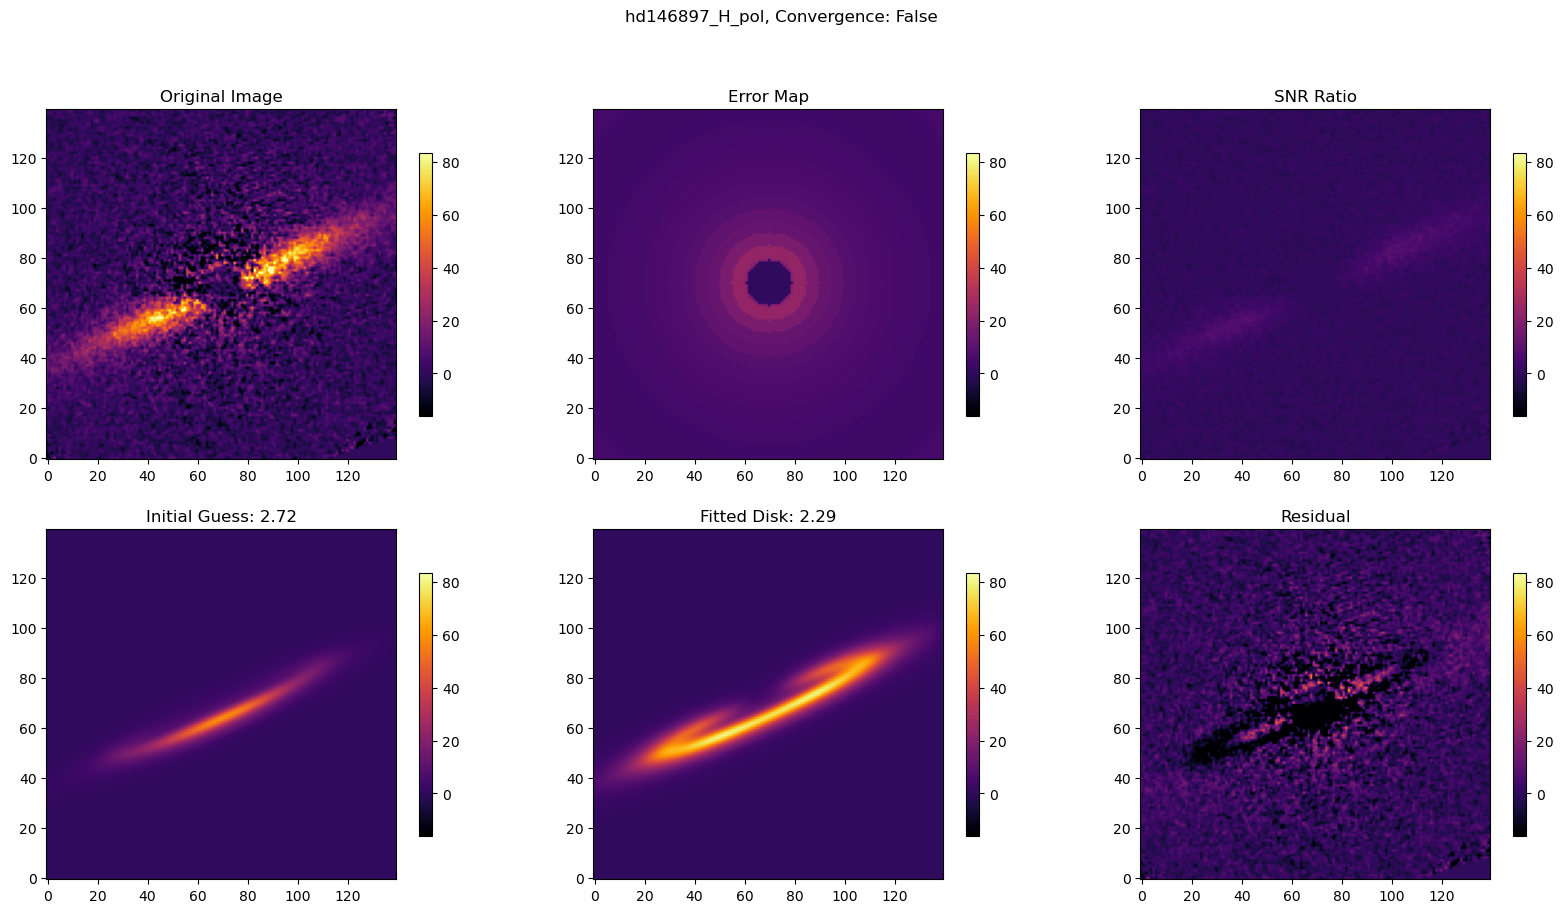

In [5]:
name = image_data.index[1]
row = image_data.loc[name]

print(row)
hdul = fits.open("Fits/"+name+".fits")
target_image = process_image(hdul['SCI'].data[1,:,:])
err_map = process_image(create_empirical_err_map(hdul['SCI'].data[2,:,:]))
soln = produce_image_fit(name, target_image, err_map, row["Radius"], row["Inclination"], row["Position Angle"], row["Distance"],
                         #knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])), dispTime=True)
                         knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])), dispTime=True)
print(soln)

### After bounds tweaking

In [6]:
print(soln)

[ 7.00902208e+01  7.07300163e+01  5.00408230e+00 -4.24096369e+00
  8.50717374e+01  8.42458914e+01  2.94212582e+02  8.43843791e-03
  6.73977189e-03  3.97803635e-03  3.83803167e-03  3.59068491e-03
  2.77377191e-03  2.67558746e-03  4.27628568e-03  2.60461878e-04]


In [7]:
from scipy.optimize import minimize

In [8]:
llp_spline = lambda x: log_likelihood_1d_pos_cent(jnp.concatenate([soln[0:7], x]), 
                    DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                    1e6, target_image, err_map, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
                    knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])))

for i in range(7, len(soln)):
    if(soln[i] <= 0):
        soln[i] = 1e-5

bounds = []
for i in range(0, int(row["Knots"])):
    bounds.append((0, 0.1))

spline = minimize(llp_spline, soln[7:], method='l-bfgs-b', bounds=bounds).x

ch_soln = jnp.concatenate([soln[0:7], spline])

print(soln)
print(ch_soln)

[ 7.00902208e+01  7.07300163e+01  5.00408230e+00 -4.24096369e+00
  8.50717374e+01  8.42458914e+01  2.94212582e+02  8.43843791e-03
  6.73977189e-03  3.97803635e-03  3.83803167e-03  3.59068491e-03
  2.77377191e-03  2.67558746e-03  4.27628568e-03  2.60461878e-04]
[ 7.0090218e+01  7.0730019e+01  5.0040822e+00 -4.2409635e+00
  8.5071739e+01  8.4245888e+01  2.9421259e+02  8.4384382e-03
  6.7397719e-03  3.9780363e-03  3.8380318e-03  3.5906848e-03
  2.7737720e-03  2.6755875e-03  4.2762859e-03  2.6046188e-04]


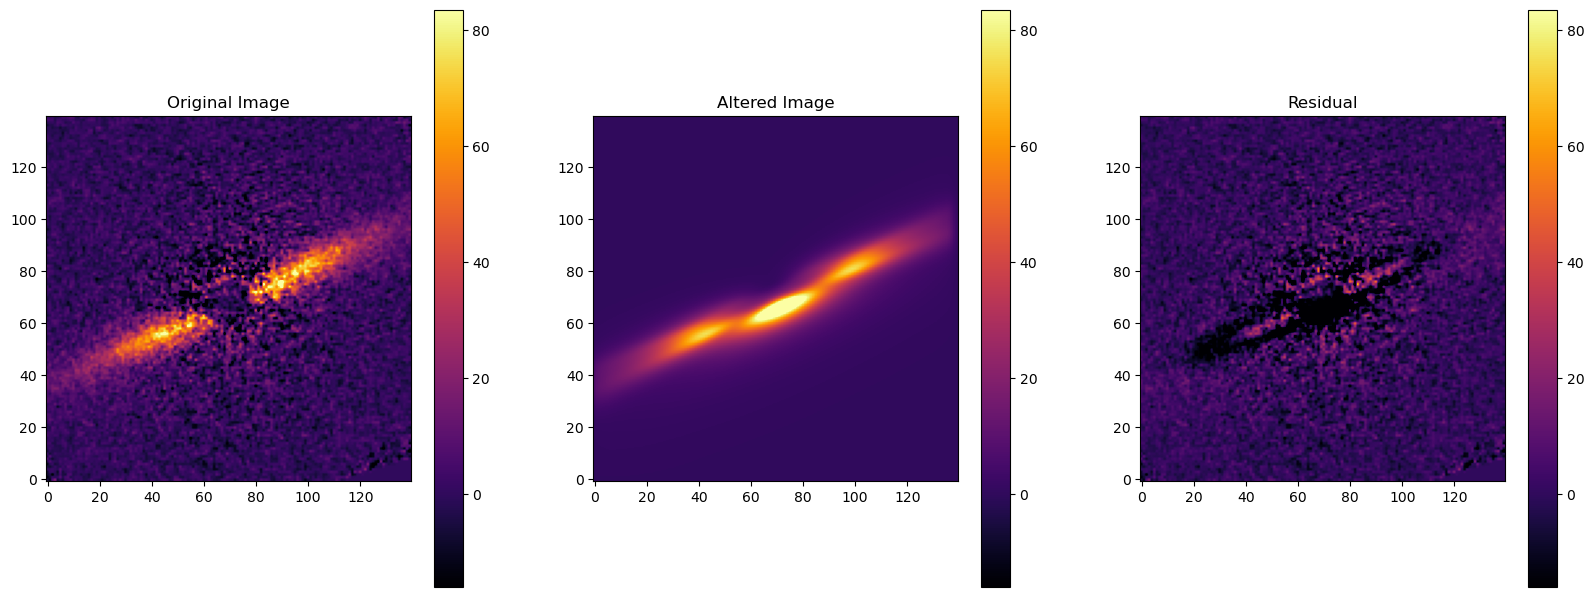

In [9]:
image_data = pd.read_csv('FitsResults/fits.csv')
image_data.columns = ["Name", "xc", "yc", "Alpha_In", "Alpha_Out", "Radius", "Inclination", "Position Angle", "Distance", "Knots"]
image_data.set_index("Name", inplace=True)
image_data.columns = ["xc", "yc", "Alpha_In", "Alpha_Out", "Radius", "Inclination", "Position Angle", "Distance", "Knots"]

name = image_data.index[1]
row = image_data.loc[name]

def fit_spline(row, target_image, err_map, disp = False, flux_scaling=1e6):

    knots = get_inc_bounded_knots(row["Inclination"], row["Radius"], buffer = 0, num_knots=int(row["Knots"]))

    init_knot_guess = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi([0.5, 0.5, 0.5], knots)
    disk_pars = jnp.array([row["xc"], row["yc"], row["Alpha_In"], row["Alpha_Out"],
                        row["Radius"], row["Inclination"], row["Position Angle"]])

    bounds = []
    for i in range(0, int(row["Knots"])):
        bounds.append((0, 0.1))

    llp_spline = lambda x: log_likelihood_1d_pos_cent(jnp.concatenate([disk_pars, x]), 
                        DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                        flux_scaling, target_image, err_map, knots=knots, distance = row["Distance"],
                        PSFModel = EMP_PSF)

    maxiters = 1000
    opt = {'disp':disp,'maxiter':maxiters}
    knot_vals = minimize(llp_spline, init_knot_guess, options = opt, method = 'l-bfgs-b', bounds=bounds).x

    if (int(row['Knots'])%2 == 0):
        knot_vals = transpose_even_to_odd_spline(knot_vals, knots,
                    get_inc_bounded_knots(row["Inclination"], row["Radius"], buffer = 0, num_knots=int(row["Knots"]+1)))

    fin_pars = jnp.concatenate([disk_pars, knot_vals])

    return fin_pars

hdul = fits.open("Fits/"+name+".fits")
target_image = process_image(hdul['SCI'].data[1,:,:])
err_map = process_image(create_empirical_err_map(hdul['SCI'].data[2,:,:])).astype(jnp.float64)
fs = fit_spline(row, target_image, err_map)
img = quick_image_cent(fs, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
                            knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])))

## Get a good scaling
y, x = np.indices(target_image.shape)
y -= 70
x -= 70 
rads = np.sqrt(x**2+y**2)
mask = (rads > 12)

vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99.9)

ch_image = quick_image_cent(ch_soln, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
                            knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])))

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno')
axes[1].set_title("Altered Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-ch_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

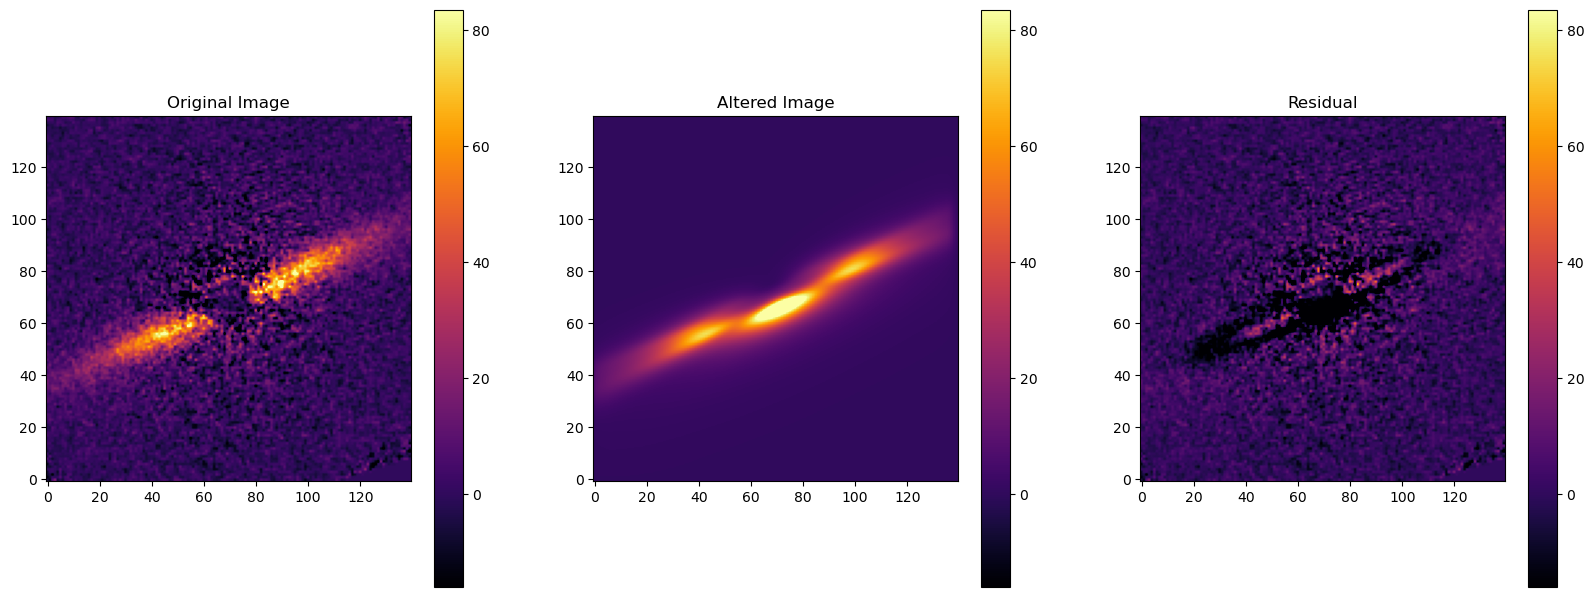

In [10]:
image_data = pd.read_csv('FitsResults/fits.csv')
image_data.columns = ["Name", "xc", "yc", "Alpha_In", "Alpha_Out", "Radius", "Inclination", "Position Angle", "Distance", "Knots"]
image_data.set_index("Name", inplace=True)
image_data.columns = ["xc", "yc", "Alpha_In", "Alpha_Out", "Radius", "Inclination", "Position Angle", "Distance", "Knots"]

name = image_data.index[1]
row = image_data.loc[name]

def fit_spline(row, target_image, err_map, disp = False, flux_scaling=1e6):

    knots = get_inc_bounded_knots(row["Inclination"], row["Radius"], buffer = 0, num_knots=int(row["Knots"]))

    init_knot_guess = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi([0.5, 0.5, 0.5], knots)
    disk_pars = jnp.array([row["xc"], row["yc"], row["Alpha_In"], row["Alpha_Out"],
                        row["Radius"], row["Inclination"], row["Position Angle"]])

    bounds = []
    for i in range(0, int(row["Knots"])):
        bounds.append((0, 0.1))

    llp_spline = lambda x: log_likelihood_1d_pos_cent(jnp.concatenate([disk_pars, x]), 
                        DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                        flux_scaling, target_image, err_map, knots=knots, distance = row["Distance"],
                        PSFModel = EMP_PSF)

    maxiters = 1000
    opt = {'disp':disp,'maxiter':maxiters}
    knot_vals = minimize(llp_spline, init_knot_guess, options = opt, method = 'l-bfgs-b', bounds=bounds).x

    if (int(row['Knots'])%2 == 0):
        knot_vals = transpose_even_to_odd_spline(knot_vals, knots,
                    get_inc_bounded_knots(row["Inclination"], row["Radius"], buffer = 0, num_knots=int(row["Knots"]+1)))

    fin_pars = jnp.concatenate([disk_pars, knot_vals])

    return fin_pars

hdul = fits.open("Fits/"+name+".fits")
target_image = process_image(hdul['SCI'].data[1,:,:])
err_map = process_image(create_empirical_err_map(hdul['SCI'].data[2,:,:])).astype(jnp.float64)
fs = fit_spline(row, target_image, err_map)
img = quick_image_cent(fs, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
                            knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])))

## Get a good scaling
y, x = np.indices(target_image.shape)
y -= 70
x -= 70 
rads = np.sqrt(x**2+y**2)
mask = (rads > 12)

vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99.9)

ch_image = quick_image_cent(ch_soln, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
                            knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])))

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno')
axes[1].set_title("Altered Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-ch_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

In [1]:
from regression import log_likelihood_1d_full_opt

In [11]:
for i in range(8, len(soln)):
    if(soln[i] <= 0):
        soln[i] = 0
if(soln[2] < 1):
    soln[2] = 1

knots = get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"]))
xvals = get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=100)

llp = lambda x: -log_likelihood_1d_pos_cent(x, 
                    DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                    1e6, target_image, err_map, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
                    knots=knots)


# 0: alpha_in, 1: alpha_out, 2: sma, 3: inclination, 4: position_angle, 5: xc, 6: yc, 7: e, 8: ksi, 9: gamma, 10: beta,
# 11: amin, 12: omega, 13 onwards is spf parameters
DISK_BOUNDS = np.array([np.array([1, -10, 0, 0, 0]), np.array([10, -1, 150, 180, 400])])
CENT_BOUNDS = np.array([np.array([65, 65]), np.array([75, 75])])
SPLINE_BOUNDS = np.array([np.zeros(jnp.size(knots)), 0.1*np.ones(jnp.size(knots))])
BOUNDS = np.array([np.concatenate([CENT_BOUNDS[0], DISK_BOUNDS[0], SPLINE_BOUNDS[0]]),
                    np.concatenate([CENT_BOUNDS[1], DISK_BOUNDS[1], SPLINE_BOUNDS[1]])])

def spline_prior(theta_bounds, theta):
    spline_model = InterpolatedUnivariateSpline_SPF.init(theta[7:], knots=knots)
    if np.all(theta > theta_bounds[0]) and np.all(theta < theta_bounds[1]) and np.all(spline_model(xvals) >= 0):
        return 0
    else:
        return -np.inf

nwalkers = 100
niter = 100
burns = 20

mc_model = MCMC_model(llp, BOUNDS)
mc_model.run(soln, nconst = 1e-7, nwalkers=nwalkers, niter=niter, burn_iter=burns)

Running burn-in...


Running production...


(<emcee.ensemble.EnsembleSampler at 0x7fad5067c050>,
 array([[7.00928540e+01, 7.07260843e+01, 5.00374142e+00, ...,
         1.99467453e-03, 2.39679777e-03, 4.42433757e-04],
        [7.00925181e+01, 7.07340087e+01, 5.00945701e+00, ...,
         4.43144168e-03, 1.97340121e-03, 1.21704866e-06],
        [7.00847769e+01, 7.07252092e+01, 5.00675278e+00, ...,
         4.64289728e-03, 2.16878579e-03, 1.68427815e-04],
        ...,
        [7.00871325e+01, 7.07279335e+01, 5.02217791e+00, ...,
         1.21448522e-02, 6.54829466e-04, 1.27041351e-03],
        [7.00989025e+01, 7.07294247e+01, 5.01411765e+00, ...,
         1.48253533e-02, 2.60377589e-03, 9.35724283e-03],
        [7.00935883e+01, 7.07333970e+01, 4.99568932e+00, ...,
         5.87741416e-05, 7.38712139e-03, 1.68421351e-03]]),
 array([ -2.30724168,  -2.43811774,  -2.33088589,  -2.47709703,
         -2.33198905,  -2.6824429 ,  -9.49523354,  -4.4651804 ,
         -2.34747338,  -3.04085398,  -5.32882261,  -2.34695244,
         -2.38001513

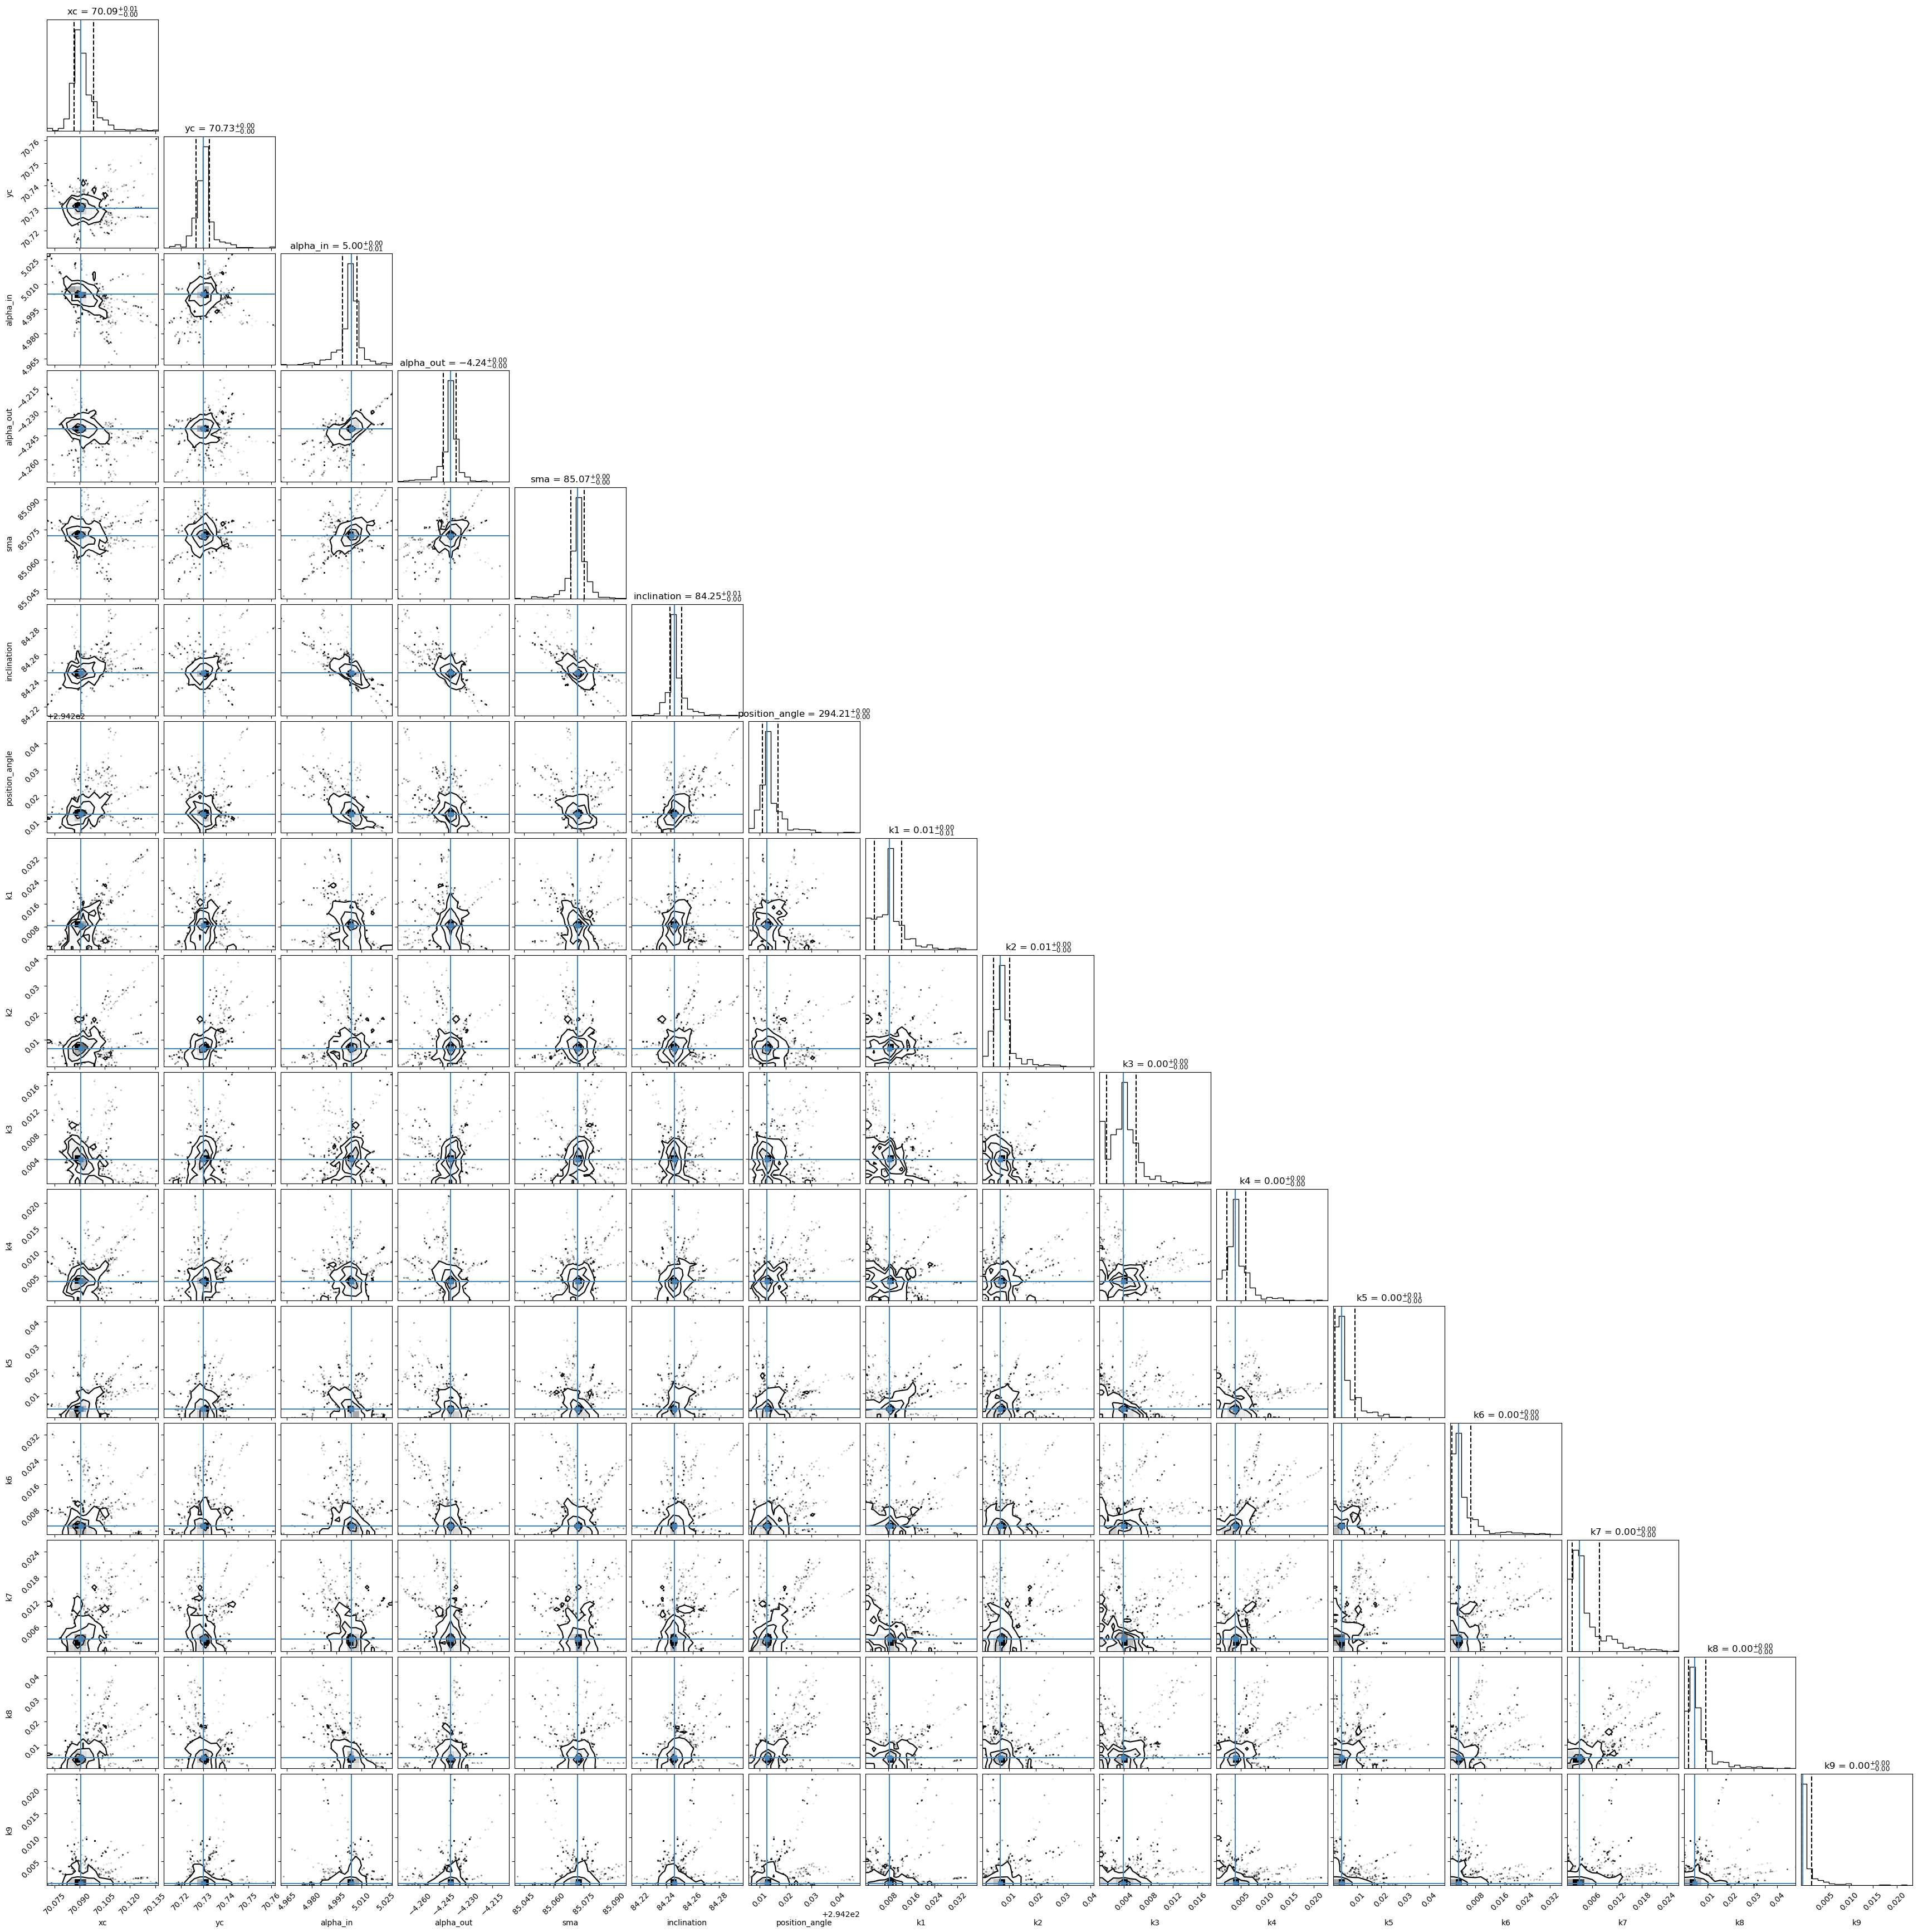

In [12]:
labels = ['xc', 'yc', 'alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle']
for i in range(0, jnp.size(knots)):
    labels.append('k'+str(i+1))
#mc_model.show_corner_plot(labels, truths=soln)
mc_model.show_corner_plot(labels, truths=np.median(mc_model.sampler.flatchain, axis=0), quiet = True)

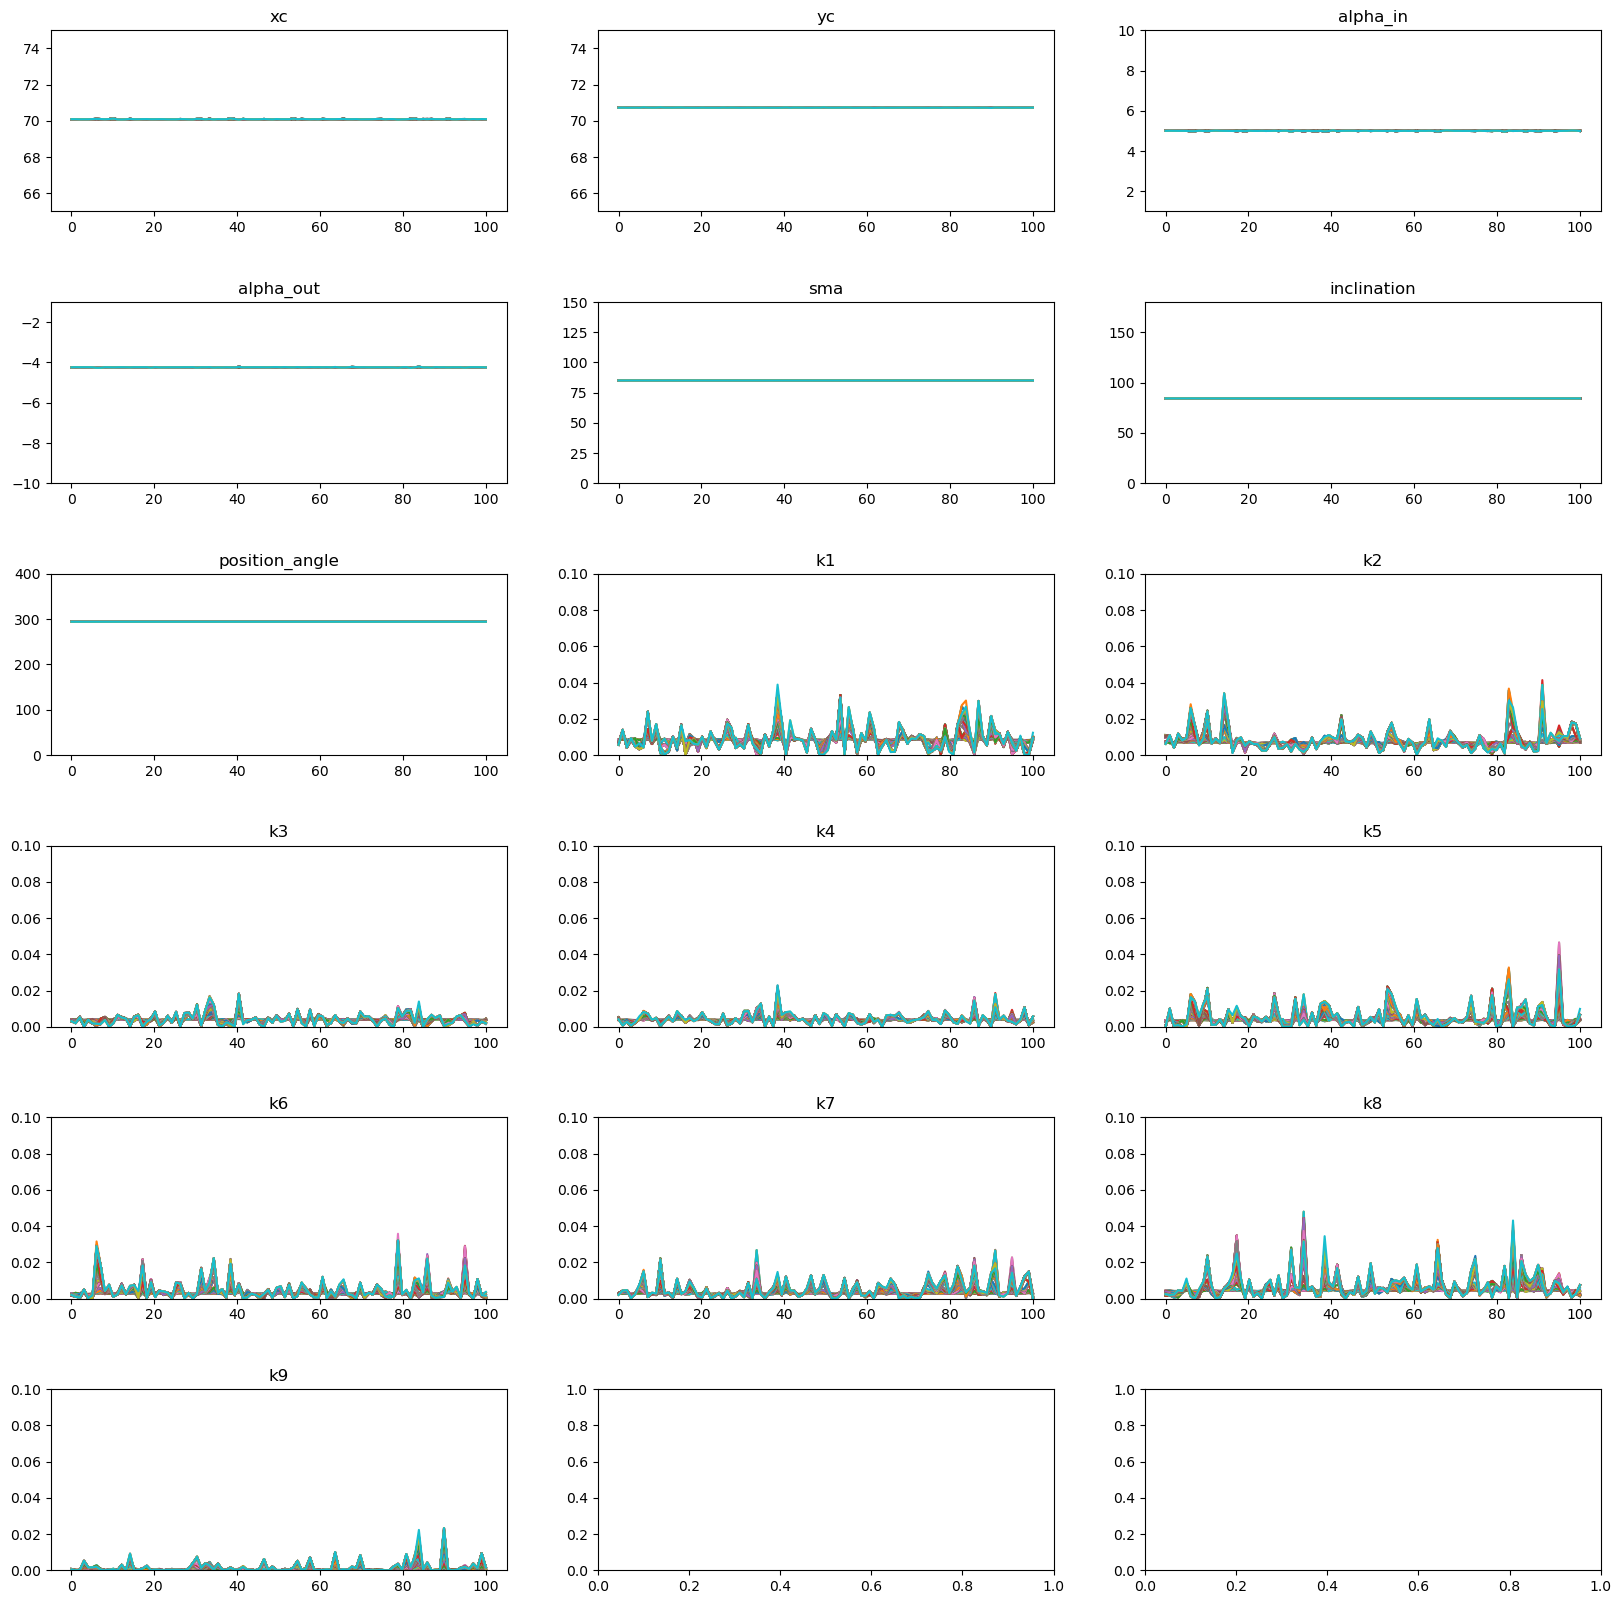

In [13]:
n_cols = int((len(soln) + 2) / 3)

fig, axes = plt.subplots(n_cols,3, figsize=(20,20))
fig.subplots_adjust(hspace=0.5)

for i in range(0, n_cols):
    for j in range(0, 3):
        if(3*i+j < len(soln)):
            axes[i][j].plot(np.linspace(0, nwalkers, niter), mc_model.sampler.get_chain()[:, :, 3*i+j].T)
            axes[i][j].set_ylim(BOUNDS[0][3*i+j], BOUNDS[1][3*i+j])
            axes[i][j].set_title(labels[3*i+j])

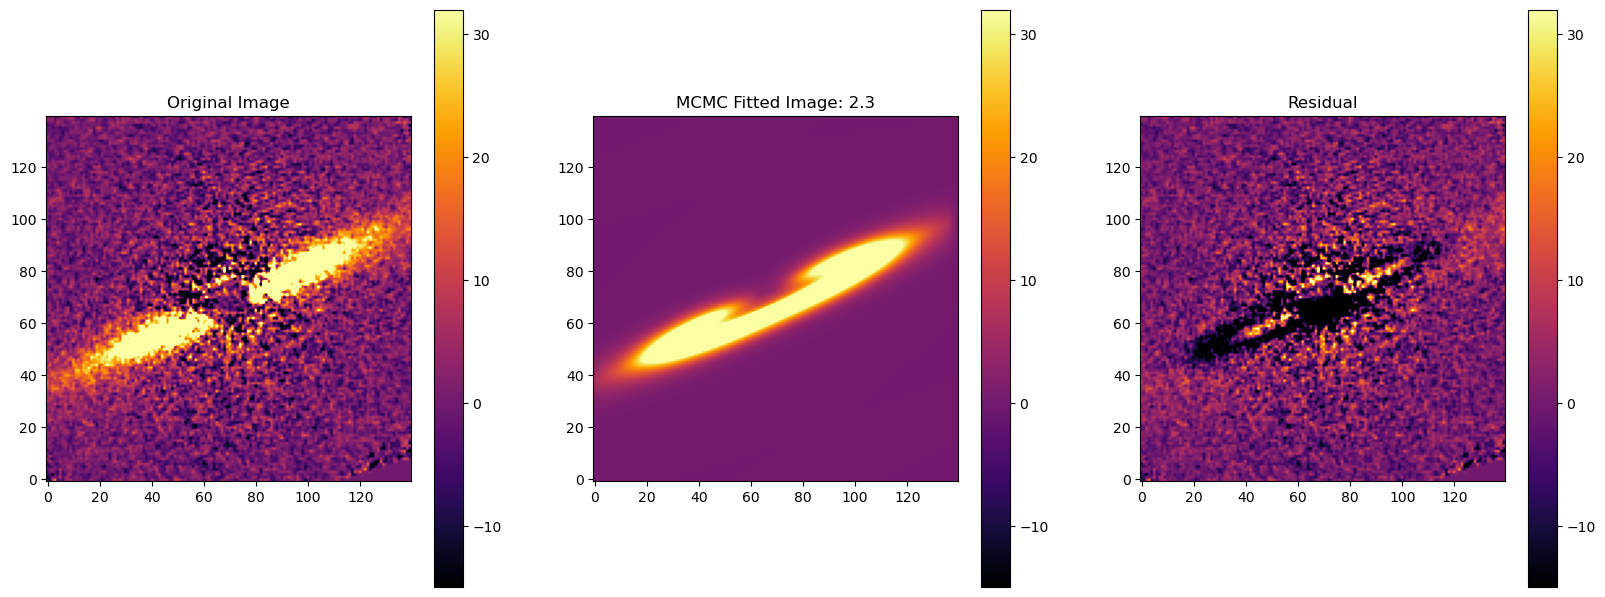

In [14]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
#mc_soln = mc_model.get_theta_max()
mc_image = quick_image_cent(mc_soln, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"], knots=knots)

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(-15, 32)

im = axes[1].imshow(mc_image, origin='lower', cmap='inferno')
axes[1].set_title("MCMC Fitted Image: " + str(round(-llp(mc_soln), 2)))
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(-15, 32)

im = axes[2].imshow(target_image-mc_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(-15, 32)

In [15]:
#fig.savefig("mcmc_results/"+name+'.png')

In [16]:
#llp_spline = lambda x: log_likelihood_1d_pos_cent(jnp.concatenate([soln[0:7], x]), 
#                    DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
#                    1e6, target_image, err_map, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
#                    knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])))

def tweak_bounds(soln, llp, num_knots):
    for i in range(7, len(soln)):
        if(soln[i] <= 0):
            soln[i] = 1e-5
    bounds = []
    for i in range(0, num_knots):
        bounds.append((0, 0.1))
    spline = minimize(llp, soln[7:], method='l-bfgs-b', bounds=bounds).x
    ch_soln = jnp.concatenate([soln[0:7], spline])
    return ch_soln

In [17]:
def transpose_even_to_odd_spline(knot_vals, knots, new_knots):
    x_vals = jnp.linspace(-1, 1, 100)
    spline = InterpolatedUnivariateSpline_SPF.init(knot_vals, knots=knots)
    y_vals = spline(x_vals)

    new_k_vals = []
    for nk in new_knots:
        new_k_vals.append(y_vals[int((nk*100 + 100)/2)])
    return jnp.array(new_k_vals)

knots = get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=9)
new_knots = get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=10)

x_vals = jnp.linspace(1, -1, 100)
init_spline = InterpolatedUnivariateSpline_SPF.init(mc_soln[7:], knots=knots)
y_vals = init_spline(x_vals)
new_k_vals = transpose_even_to_odd_spline(mc_soln[7:], knots, new_knots)
new_spline = InterpolatedUnivariateSpline_SPF.init(new_k_vals, knots=new_knots)
new_y_vals = new_spline(x_vals)

#plt.vlines(knots, -0.03, 0.015)
#plt.plot(x_vals, y_vals, color = 'g')
#plt.plot(x_vals, new_y_vals, color = 'r')
#plt.axvspan(-1, np.cos((180-row['Inclination'])*np.pi/180), color='grey', alpha=0.5)
#plt.axvspan(np.cos(row['Inclination']*np.pi/180), 1, color='grey', alpha=0.5)
#plt.show()

### AIC BIC

In [18]:
# AIC = -2 * ln(L) + 2*k

def get_aic(pos_log_likelihood, num_params):
    return 2 * pos_log_likelihood + 2 * num_params

def get_bic(pos_log_likelihood, num_params):
    return 2 * pos_log_likelihood + np.log(140*140) * num_params

def run_mcmc_ab(name, row, num_knots, dispRow = False):

    knots = get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=num_knots)

    if(dispRow):
        print(row)
    hdul = fits.open("Fits/"+name+".fits")
    target_image = process_image(hdul['SCI'].data[1,:,:])
    err_map = process_image(create_empirical_err_map(hdul['SCI'].data[2,:,:]))
    soln = produce_image_fit(name, target_image, err_map, row["Radius"], row["Inclination"], row["Position Angle"], row["Distance"],
                            #knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=int(row["Knots"])), dispTime=True)
                            knots=knots, dispTime=False, plot = False, disp=False)

    if(num_knots%2==0):
        new_knots = get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=num_knots)
        soln = np.concatenate([soln[0:7], transpose_even_to_odd_spline(soln[7:], knots, new_knots)])
        knots = new_knots

    llp_spline = lambda x: log_likelihood_1d_pos_cent(jnp.concatenate([soln[0:7], x]), 
                    DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                    1e6, target_image, err_map, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
                    knots=knots)

    soln = tweak_bounds(soln, llp_spline, jnp.size(knots))

    xvals = get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=100)

    llp = lambda x: -log_likelihood_1d_pos_cent(x, 
                        DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, 
                        1e6, target_image, err_map, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"],
                        knots=knots)


    DISK_BOUNDS = np.array([np.array([1, -10, 0, 0, 0]), np.array([10, -1, 150, 180, 400])])
    CENT_BOUNDS = np.array([np.array([65, 65]), np.array([75, 75])])
    SPLINE_BOUNDS = np.array([np.zeros(jnp.size(knots)), 0.1*np.ones(jnp.size(knots))])
    BOUNDS = np.array([np.concatenate([CENT_BOUNDS[0], DISK_BOUNDS[0], SPLINE_BOUNDS[0]]),
                        np.concatenate([CENT_BOUNDS[1], DISK_BOUNDS[1], SPLINE_BOUNDS[1]])])

    nwalkers = 100
    niter = 100
    burns = 20

    mc_model = MCMC_model(llp, BOUNDS)
    mc_model.run(soln, nconst = 1e-7, nwalkers=nwalkers, niter=niter, burn_iter=burns)

    mc_soln = np.median(mc_model.sampler.flatchain, axis=0)

    return mc_soln, get_aic(llp(mc_soln), len(mc_soln)), get_bic(llp(mc_soln), len(mc_soln))

In [19]:
name = image_data.index[18]
row = image_data.loc[name]
mc_soln, aic, bic = run_mcmc_ab(name, row, 9)

Running burn-in...
Running production...


In [20]:
name = image_data.index[18]
row = image_data.loc[name]

min_soln = None
min_aic = 1e6
#start = (int(row['Knots']) - 6) if (row['Knots'] >= 9) else 5
#end = int(row['Knots']) + 6
start = 5
end = 11
for i in range(start, end+1, 2):
    soln, aic, bic = run_mcmc_ab(name, row, i)
    if aic < min_aic:
        min_aic = aic
        min_soln = soln
    print("Number of knots: " + str(i))
    print("AIC: " + str(aic))
    print("BIC: " + str(bic))
    print(soln)
    print()

print("Min Knots: " + str(len(min_soln[7:])))

Running burn-in...
Running production...
Number of knots: 5
AIC: 19.553307
BIC: 114.152725
[ 6.99998841e+01  7.00001615e+01  5.00000337e+00 -4.99996899e+00
  7.90723950e+01  3.54257527e+01  2.80900262e+02  2.26309148e-03
  4.46897317e-03  2.55205745e-03  2.28014262e-03  7.34199298e-04]

Running burn-in...
Running production...
Number of knots: 7
AIC: 23.75503
BIC: 134.12102
[ 6.99007701e+01  7.09657879e+01  1.00407947e+00 -4.85721725e+00
  7.80732198e+01  3.58586460e+01  2.80905160e+02  2.76108097e-03
  3.30095682e-03  2.34421530e-03  1.60156822e-03  2.33864075e-03
  2.41951382e-03  7.66027978e-04]

Running burn-in...
Running production...
Number of knots: 9
AIC: 27.551249
BIC: 153.6838
[ 6.99999404e+01  7.00000445e+01  4.99980522e+00 -4.99978367e+00
  7.90722582e+01  3.54256078e+01  2.80900308e+02  3.46108122e-03
  3.34322870e-03  2.84521675e-03  2.47405466e-03  9.03788254e-04
  2.43910907e-03  9.12470953e-04  1.67807836e-03  2.84479666e-04]

Running burn-in...
Running production...
N

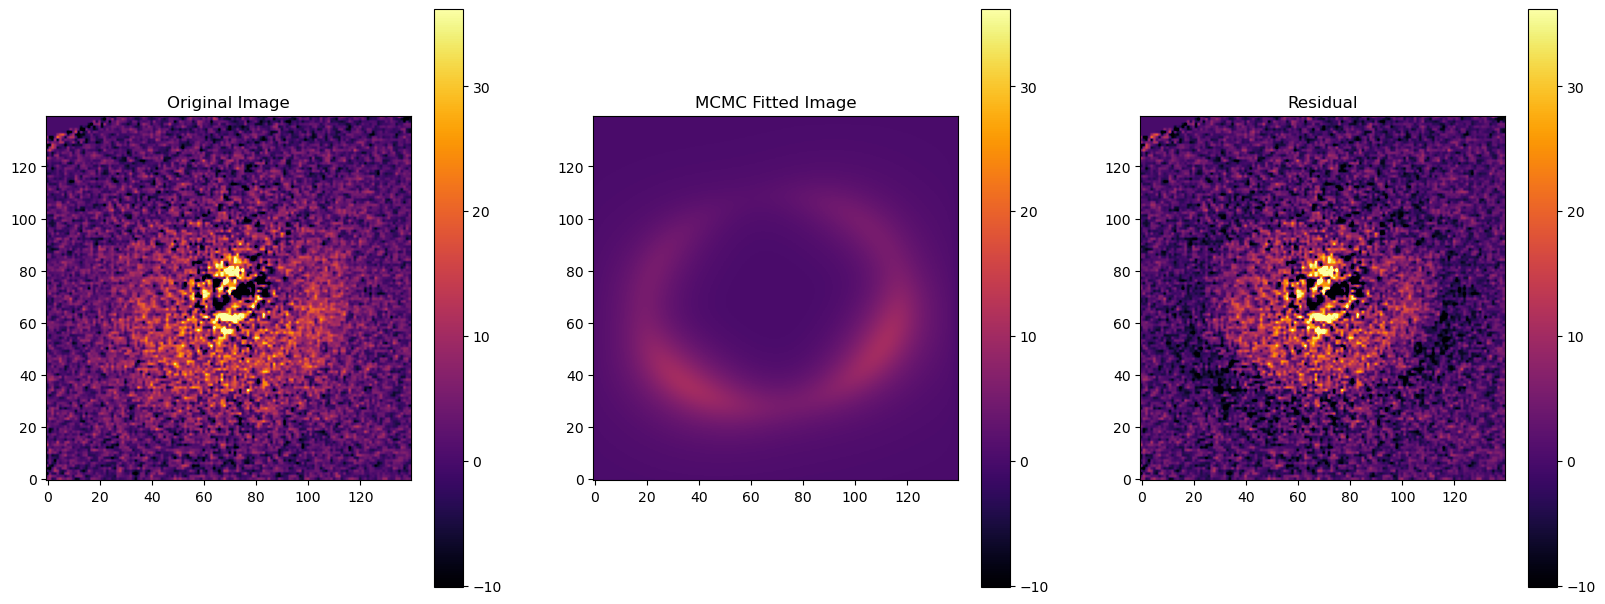

In [21]:
hdul = fits.open("Fits/"+name+".fits")
target_image = process_image(hdul['SCI'].data[1,:,:])

y, x = np.indices(target_image.shape)
y -= 70
x -= 70 
rads = np.sqrt(x**2+y**2)
mask = (rads > 12)

vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99.9)

knots = get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=jnp.size(min_soln[7:]))

mc_image = quick_image_cent(min_soln, PSFModel = EMP_PSF, pxInArcsec=0.01414, distance = row["Distance"], knots=knots)

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(mc_image, origin='lower', cmap='inferno')
axes[1].set_title("MCMC Fitted Image")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-mc_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

### Using AIC/BIC for all Disks

In [22]:
knots = []
length = len(image_data)

for i in range(0, len(image_data)):
    name = image_data.index[i]
    row = image_data.loc[name]

    st = datetime.now()
    print(str(i+1) + " of " + str(length))

    min_knots = 5
    min_aic = 1e6
    #start = (int(row['Knots']) - 6) if (row['Knots'] >= 9) else 5
    #end = int(row['Knots']) + 6
    start = 5
    end = 11
    if(int(row['Knots']) % 2 == 0):
        start+=1
        end+=1
    for i in range(start, end+1, 2):
        soln, aic, bic = run_mcmc_ab(name, row, i)
        if aic < min_aic:
            min_aic = aic
            min_knots = i
        print("Number of knots: " + str(i))
        print("AIC: " + str(aic))
        print("BIC: " + str(bic))
        print(soln)
        print()

    print("Time taken: " + str(datetime.now()-st))
    print("Minimum Knots: " + str(min_knots))
    print("\n\n")
    
    knots.append(min_knots)

print(knots)

1 of 19


Running burn-in...
Running production...
Number of knots: 5
AIC: 20.21458
BIC: 114.814
[ 7.02805550e+01  7.00497417e+01  4.79788903e+00 -3.98648417e+00
  7.86042575e+01  4.49191509e+01  2.21449778e+02  2.17037686e-03
  2.24976071e-03  1.61598506e-03  1.13749954e-03  9.37179402e-04]

Running burn-in...
Running production...
Number of knots: 7
AIC: 24.213142
BIC: 134.57913
[ 7.04197553e+01  7.02256036e+01  4.34624185e+00 -3.52747239e+00
  7.85012942e+01  4.45851069e+01  2.21335842e+02  1.79971242e-03
  2.05063568e-03  1.23572463e-03  1.99569228e-03  3.62765050e-04
  5.43885284e-04  2.91699165e-04]

Running burn-in...
Running production...
Number of knots: 9
AIC: 28.209843
BIC: 154.34239
[ 7.04272155e+01  7.01480038e+01  4.12876173e+00 -2.95138640e+00
  7.84974552e+01  4.48750426e+01  2.21537126e+02  2.52428937e-03
  2.19527409e-03  1.49655432e-03  1.84966585e-03  5.74579946e-04
  1.23709656e-03  1.99938362e-04  4.31403417e-04  2.87545801e-05]

Running burn-in...
Running production...
Num

Traceback (most recent call last):
  File "/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mihirkondapalli/sldjax/DiskRegression/mcmc_model.py", line 28, in _lnprob
    return lp + self.fun(theta)
                ^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_309382/1520912799.py", line 36, in <lambda>
    llp = lambda x: -log_likelihood_1d_pos_cent(x,
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

: 

In [ ]:
print(knots)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5]


In [ ]:
'''knot_vals = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5]

amnt = len(image_data)
ind = 0

for i in range(0, amnt):
    name = image_data.index[i]
    row = image_data.loc[name]
    print(row)
    hdul = fits.open("Fits/"+name+".fits")
    target_image = process_image(hdul['SCI'].data[1,:,:])
    err_map = process_image(create_empirical_err_map(hdul['SCI'].data[2,:,:])).astype(jnp.float64)
    soln = produce_image_fit(name, target_image, err_map, row["Radius"], row["Inclination"], row["Position Angle"], row["Distance"], method = None,
                             full=False, disp = False, dispTime=True,
                             knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=knot_vals[i]))
    print(soln)
    ind+=1
    print(str(ind)+' out of '+str(amnt)+' done')
    print()
    plt.savefig("FitsResults/"+name+'.png')'''

'knot_vals = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5]\n\namnt = len(image_data)\nind = 0\n\nfor i in range(0, amnt):\n    name = image_data.index[i]\n    row = image_data.loc[name]\n    print(row)\n    hdul = fits.open("Fits/"+name+".fits")\n    target_image = process_image(hdul[\'SCI\'].data[1,:,:])\n    err_map = process_image(create_empirical_err_map(hdul[\'SCI\'].data[2,:,:])).astype(jnp.float64)\n    soln = produce_image_fit(name, target_image, err_map, row["Radius"], row["Inclination"], row["Position Angle"], row["Distance"], method = None,\n                             full=False, disp = False, dispTime=True,\n                             knots=get_inc_bounded_knots(row["Inclination"], row["Radius"], num_knots=knot_vals[i]))\n    print(soln)\n    ind+=1\n    print(str(ind)+\' out of \'+str(amnt)+\' done\')\n    print()\n    plt.savefig("FitsResults/"+name+\'.png\')'

: 